# Common utils

In [26]:
import json
from pathlib import Path
from typing import TypedDict, Sequence

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.ioff()

NUM_SIMULATIONS=10

class ExperimentMetrics(TypedDict):
    centralized: pd.DataFrame
    single: pd.DataFrame
    gossip: dict[str, pd.DataFrame]
    gen_centralized: pd.DataFrame
    gen_single: pd.DataFrame
    gen_gossip: dict[str, pd.DataFrame]
    
    
class NodeTraffic(TypedDict):
    sent: int
    received: int
    
    
class HistoryData(TypedDict):
    num_trainings: tuple[int, ...]
    node_traffic: NodeTraffic

def extract_experiment_metrics(experiment_names: tuple[str, ...]) -> ExperimentMetrics:
    experiment_metrics = { 
        exp: [pd.read_csv(f"experiments/{exp}/{i}/metrics.csv", index_col=0) for i in range(NUM_SIMULATIONS)]
        for exp in experiment_names
    }
    
    experiment_generalization_metrics = { 
        exp: [pd.read_csv(f"experiments/{exp}/{i}/generalization_metrics.csv", index_col=0) for i in range(NUM_SIMULATIONS)]
        for exp in experiment_names
   }
    
    first_exp_metrics = experiment_metrics[experiment_names[0]]
    first_exp_gen_metrics = experiment_generalization_metrics[experiment_names[0]]
    centralized_metrics = []
    single_metrics = []
    centralized_gen_metrics = []
    single_gen_metrics = []
    
    
    for i in range(NUM_SIMULATIONS):
        df = first_exp_metrics[i]
        df_centralized_metrics = df[df.index.str.match("centralized [0-9]+")]
        centralized_metrics.append(df_centralized_metrics)
    
        df_single_metrics = df[df.index.str.match("single [0-9]+")]
        single_metrics.append(df_single_metrics)
        
        df_gen = first_exp_gen_metrics[i]
        df_gen_centralized_metrics = df_gen[df_gen.index.str.match("centralized [0-9]+")]
        centralized_gen_metrics.append(df_gen_centralized_metrics)
        df_gen_single_metrics = df_gen[df_gen.index.str.match("single [0-9]+")]
        single_gen_metrics.append(df_gen_single_metrics)
        
    centralized_metrics_df = pd.concat(centralized_metrics)
    single_metrics_df = pd.concat(single_metrics)
    centralized_gen_metrics_df = pd.concat(centralized_gen_metrics)
    single_gen_metrics_df = pd.concat(single_gen_metrics)
    
    gossip_metrics: dict[str, pd.DataFrame] = {}
    gossip_gen_metrics: dict[str, pd.DataFrame] = {}
    
    for exp in experiment_names:
        metrics = []
        gen_metrics = []
        
        for i in range(NUM_SIMULATIONS):
            df = experiment_metrics[exp][i]
            df_gossip_metrics = df[df.index.str.match("gossip [0-9]+")]
            metrics.append(df_gossip_metrics)
            
            df_gen = experiment_generalization_metrics[exp][i]
            df_gen_gossip_metrics = df_gen[df_gen.index.str.match("gossip [0-9]+")]
            gen_metrics.append(df_gen_gossip_metrics)
            
        gossip_metrics[exp] = pd.concat(metrics)
        gossip_gen_metrics[exp] = pd.concat(gen_metrics)
        

    
    return {
        "centralized": centralized_metrics_df,
        "single": single_metrics_df,
        "gossip": gossip_metrics,
        "gen_centralized": centralized_gen_metrics_df,
        "gen_single": single_gen_metrics_df,
        "gen_gossip": gossip_gen_metrics,
    }

def get_history_data(exp_names: tuple[str, ...], n_nodes: int = 10) -> dict[str, HistoryData]:
    exp_histories = {
        exp: [json.load(open(f"experiments/{exp}/{i}/history.json", "r")) for i in range(NUM_SIMULATIONS)]
        for exp in exp_names
    }
    
    training_epochs: dict[str, list[int]] = {}
    for exp in exp_names:
        trainings = []
        for history in exp_histories[exp]:
            nodes = {i: 0 for i in range(n_nodes)}
            for t in history["trainings"]:
                nodes[t["node"]] += 1
            trainings += [t for t in nodes.values()]
        training_epochs[exp] = trainings
    
    node_traffic: dict[str, NodeTraffic] = {}
    for exp in exp_names:
        sent = []
        received = []
        for history in exp_histories[exp]:
            nodes = {i: {"sent": 0, "received": 0} for i in range(n_nodes)}
            for msg in history["messages"]:
                nodes[msg["from_node"]]["sent"] += 1
                nodes[msg["to_node"]]["received"] += 1
                
            sent += [traffic["sent"] for traffic in nodes.values()]
            received += [traffic["received"] for traffic in nodes.values()]
        node_traffic[exp] = {"sent": sent, "received": received}
    
    return {
        exp: {
            "num_trainings": training_epochs[exp],
            "node_traffic": node_traffic[exp],
        } 
        for exp in exp_names
    }


def metric_comparison_plot(metrics: ExperimentMetrics, file: str, metric: str = "mse", size: tuple[int, int] = (6,6), include_benchmark: bool = True) -> None:    
    data = [metrics["gossip"][exp][metric] for exp in experiments.keys()]
    xticks = [v for v in experiments.values()]
    
    if include_benchmark:
        data = [metrics["centralized"][metric], metrics["single"][metric]] + data
        xticks = ["Centralized", "Single"] + xticks
    
    boxplot(data, file=file, xlabels=xticks, size=size, y_title="MSE", x_title="Experiment")
    
def generalization_metric_comparison_plot(metrics: ExperimentMetrics, file: str, metric: str = "mse", size: tuple[int, int] = (6,6), include_benchmark: bool = True) -> None:
    data = [metrics["gen_gossip"][exp][metric] for exp in experiments.keys()]
    xticks = [v for v in experiments.values()]
    
    if include_benchmark:
        data = [metrics["gen_centralized"][metric], metrics["gen_single"][metric]] + data
        xticks = ["Centralized", "Single"] + xticks
        
    boxplot(data, file=file, xlabels=xticks, size=size, y_title="MSE", x_title="Experiment")    
    
    
def boxplot(
        data: list[pd.Series], 
        file: str, 
        xlabels: Sequence[str],
        title: str | None = None,
        size: tuple[int, int] = (6,6),
        x_title: str | None = None,
        y_title: str | None = None
        ) -> None:
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=size)
    sns.boxplot(pd.DataFrame(data={
        xlabels[i]: data[i].to_list()
        for i in range(len(xlabels))
    }), ax=ax, whis=[0, 95])
    ax.grid(visible=True, axis="y")
    if title:
        ax.set_title(title)
    
    if x_title:
        ax.set_xlabel(x_title)
    if y_title: 
        ax.set_ylabel(y_title)
    
    plt.savefig(file, dpi=500, format="svg", bbox_inches='tight')

In [23]:
def exp_metrics_to_table(exp_metrics: ExperimentMetrics) -> pd.DataFrame:
    
    res = pd.DataFrame(
        data={
            "mean": [
                exp_metrics["centralized"]["mse"].mean(),
                exp_metrics["single"]["mse"].mean(),
            ],
            "st dev": [
                exp_metrics["centralized"]["mse"].std(),
                exp_metrics["single"]["mse"].std(),
            ],
            "generalization mean": [
                exp_metrics["gen_centralized"]["mse"].mean(),
                exp_metrics["gen_single"]["mse"].mean(),
            ],
            "generalization st dev": [
                exp_metrics["gen_centralized"]["mse"].std(),
                exp_metrics["gen_single"]["mse"].std(),
            ]
        },
        index=["centralized", "single"]
    )
    
    for exp_key in exp_metrics["gossip"].keys():
        exp_name = experiments[exp_key]
        metrics = exp_metrics["gossip"][exp_key]
        gen_metrics = exp_metrics["gen_gossip"][exp_key]
        res.loc[exp_name] = [metrics["mse"].mean(), metrics["mse"].std(), gen_metrics["mse"].mean(), gen_metrics["mse"].std()]
        
    return res

### Train-val-test split

In [83]:
df = pd.read_parquet("data/datasets/porto_10n_3k/0/node_0_notscaled.parquet")

In [84]:
reduced_df = df.loc[df.index[round(len(df)*0.95):]]

test_start = round(len(reduced_df) * 0.7)
val_start = round(test_start * 0.9)

In [85]:
train = reduced_df["requests"].loc[reduced_df.index[:val_start]]
val = reduced_df["requests"].loc[reduced_df.index[val_start:test_start]]
test = reduced_df["requests"].loc[reduced_df.index[test_start:]]

In [86]:
p = pd.period_range(start=train.index[0], end=test.index[-1], freq="W")


In [87]:
p

PeriodIndex(['2014-06-09/2014-06-15', '2014-06-16/2014-06-22',
             '2014-06-23/2014-06-29', '2014-06-30/2014-07-06'],
            dtype='period[W-SUN]')

In [100]:
from matplotlib import dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(train, label="Train", color="green")
ax.plot(val, label="Validation", color="red")
ax.plot(test, label="Test", color="blue")

p = pd.period_range(start=train.index[0], end=test.index[-1], freq='M')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))

ax.legend(framealpha=1, fontsize="large", loc="lower right")

plt.savefig("plots/time_series.svg", format="svg",  bbox_inches='tight')

### Merge straties with 3k network

In [24]:
experiments = {
    "porto_82": "Average",
    "porto_83": "Overwrite",
    "porto_84": "Weighted Average",
    "porto_80": "Weighted Overwrite",
}

folder = Path("plots/merge_strategies_3k")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)

In [13]:
exp_metrics_to_table(metrics)

,mean,st dev,generalization mean,generalization st dev
centralized,1321.772574,1410.167634,1324.371112,705.455491
single,1509.578358,2781.579084,7543.945536,9901.705242
Average,1307.245059,1461.516724,3355.304729,3486.582995
Overwrite,1462.062006,1999.660091,3787.884206,4386.828565
Weighted Average,1309.246300,1460.985996,3256.343251,3205.003488
Weighted Overwrite,1339.384797,1487.904585,4004.054209,5835.759269


### Merge strategies with 1k network

In [262]:
experiments = {
    "porto_94": "Ovw",
    "porto_95": "Improved ovw",
    "porto_96": "Avg",
    "porto_97": "W. Avg",
}

folder = Path("plots/merge_strategies_1k")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(10, 6))
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(10, 6))


In [263]:
exp_metrics_to_table(metrics)

,mean,st dev,generalization mean,generalization st dev
centralized,1367.178514,1456.910077,1226.682780,996.539768
single,1329.983773,1443.235088,5231.003066,10190.061156
Ovw,1362.822672,1537.536970,2681.050592,4262.518463
Improved ovw,1323.876512,1459.418872,2757.802967,5095.367936
Avg,1304.986390,1454.032812,2714.144211,4190.197426
W. Avg,1305.048019,1454.718027,2509.406829,3321.666011


### Fine tuning

In [264]:
experiments = {
    "porto_83": "Ovw",
    "porto_102": "Ovw FT",
    "porto_80": "Imp. ovw",
    "porto_103": "Imp. ovw FT",
    "porto_82": "Avg",
    "porto_104": "Avg FT",
    "porto_84": "W. Avg",
    "porto_105": "W. Avg FT",
}

folder = Path("plots/FT")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(10, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(10,6), include_benchmark=False)

### Serialize optimizer

In [16]:
experiments = {
    "porto_83": "Overwrite",
    "porto_88": "Overwrite Opt",
    "porto_80": "W. Overwrite",
    "porto_89": "W. Overwrite Opt",
}

folder = Path("plots/opt")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(10, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(10,6), include_benchmark=False)


### Merge multiple models

In [4]:
experiments = {
    "porto_84": "W. Avg",
    "porto_91": "W. AVG 3 models",
}

folder = Path("plots/multiple_models")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(10, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(10,6), include_benchmark=False)



### Compression

In [27]:
experiments = {
    "porto_87": "20%",
    "porto_119": "40%",
    "porto_121": "60%",
    "porto_123": "80%",
    "porto_84": "100%",
}

folder = Path("plots/compression")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)


### Target Probability

In [8]:
experiments = {
    "porto_127": "25%",
    "porto_84": "50%",
    "porto_131": "75%",
    "porto_117": "100%",
}

folder = Path("plots/target_probability")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "wavg_mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "wavg_gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)

experiments = {
    "porto_124": "25%",
    "porto_83": "50%",
    "porto_128": "75%",
    "porto_114": "100%",
}

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "ovw_mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "ovw_gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)

### Early stopping

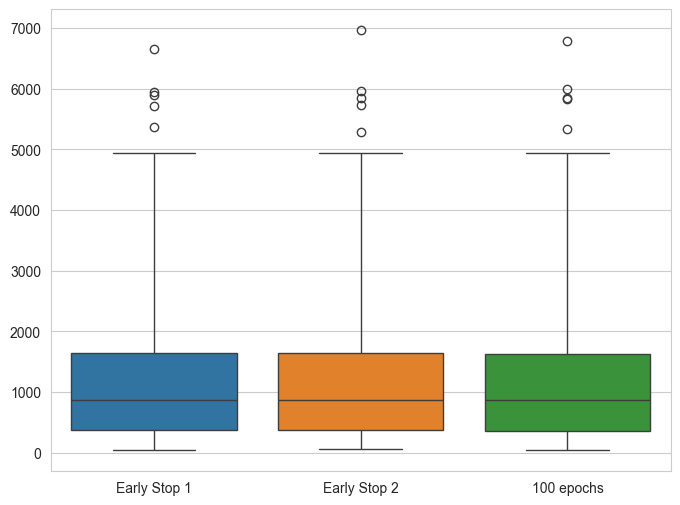

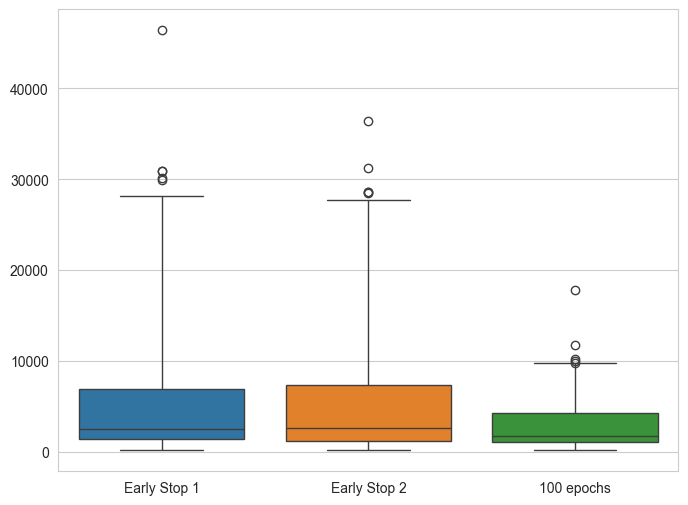

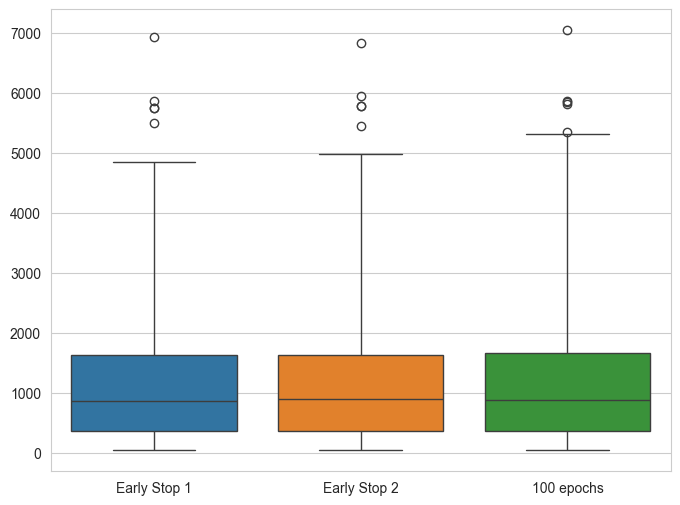

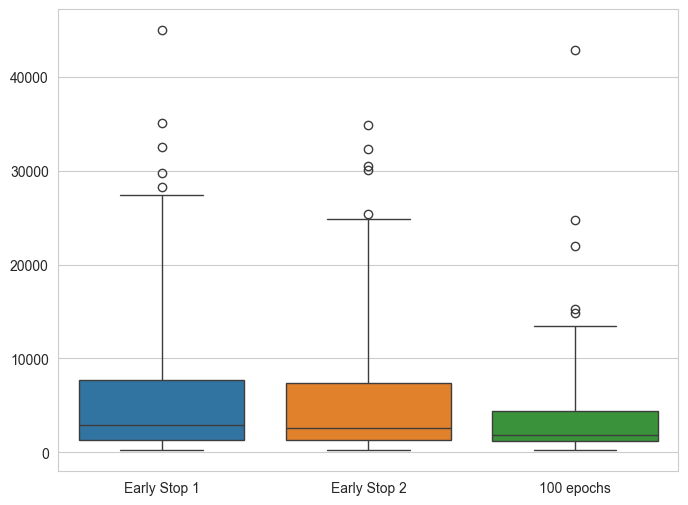

In [3]:
experiments = {
    "porto_177": "Early Stop 1",
    "porto_181": "Early Stop 2",
    "porto_84": "100 epochs"
}

folder = Path("plots/early_stopping")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "wavg_mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "wavg_gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)

experiments = {
    "porto_184": "Early Stop 1",
    "porto_180": "Early Stop 2",
    "porto_80": "100 epochs"
}

folder = Path("plots/early_stopping")
folder.mkdir(parents=True, exist_ok=True)

metrics = extract_experiment_metrics(tuple(experiments.keys()))
metric_comparison_plot(metrics, file=folder / "wovw_mse.svg", metric="mse", size=(8, 6), include_benchmark=False)
generalization_metric_comparison_plot(metrics, file=folder / "wovw_gen_mse.svg", metric="mse", size=(8,6), include_benchmark=False)

### Number of messages

In [266]:
experiments = ("porto_132", "porto_133", "porto_117", "porto_134", "porto_135", "porto_136", "porto_137", "porto_138", "porto_139")
n_nodes = 10

In [267]:
from gossiplearning import History

histories: dict[str, dict[int, History]] = {}

for exp in experiments:
    histories[exp] = {}
    for i in range(n_nodes):
        with (Path("experiments" ) / exp / str(i) / "history.json").open("r") as f:
            history_dict = json.load(f)
            h = History(**history_dict)
            histories[exp][i] = h

In [268]:
messages_sent = [
    [len(h.messages) / n_nodes for h in histories[exp].values()] 
    for exp in experiments
]

In [269]:
Path("plots/messages").mkdir(parents=True, exist_ok=True)
boxplot(
    data=[
        pd.Series(m)
        for m in messages_sent
    ], 
    xlabels=tuple(f"{i}" for i in range(1, 10)), 
    title="Messages sent in a 10-nodes k-edge connected graph", 
    file="plots/messages/by_connectivity_10n.svg",
    size=(10, 6),
    x_title="K",
    y_title="Messages/node"
)

In [3]:
from sklearn.linear_model import LinearRegression
from typing import Mapping


def number_of_msg_plot(experiments: Mapping[str, str], file: str, title: str, legend: dict[str, str] | None = None, fit_by_group: bool = False, show_fit: bool = True) -> None:
    
    
    groups: dict[str, tuple[float, int]] = {}    
    
    for exp, color in experiments.items():
        for j in range(NUM_SIMULATIONS):
            folder = Path("experiments") / exp / str(j)
            with (folder / "config.json").open("r") as f:
                config = json.load(f)
                
            with (folder / "history.json").open("r") as f:
                history = json.load(f)
                
            num_nodes = config["n_nodes"]
            num_edges = sum(len(node["links"]) for node in config["nodes"]) / 2
            num_messages = len(history["messages"])
            
            edges_nodes, messages = groups.get(color, ([], []))
            
            edges_nodes.append(num_edges / num_nodes)
            messages.append(num_messages / num_nodes)
                        
            groups[color] = (edges_nodes, messages)
        

            
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    
    
    for color, (edges_nodes, messages) in groups.items():            
        
        
        label = legend[color] if legend else None
        ax.scatter(x=edges_nodes, y=messages, c=color, label=label, s=10)
        
    
    
    if fit_by_group:
        for color, (edges_nodes, messages) in groups.items():
            model = LinearRegression()
            X = np.array(edges_nodes).reshape(len(edges_nodes), 1)
            y = np.array(messages)
            model.fit(X, y)
            
            if show_fit:
                ax.axline((0, model.intercept_), slope=model.coef_, color=color, linestyle="dashed")
                
            print(model.coef_, model.intercept_, model.score(X, y))
            
    else:
        model = LinearRegression()
        X = []
        y = []
        
        for edges_nodes, messages in groups.values():
            X.extend(edges_nodes)
            y.extend(messages)
            
        X = np.array(X).reshape((len(X), 1))
        y = np.array(y)
        model.fit(X, y)
        
        print(model.coef_, model.intercept_, model.score(X, y))
        
        if show_fit:
            ax.axline((0, model.intercept_), slope=model.coef_, color='black', linestyle="dashed")
        
    ax.set_xlabel("Edges/nodes ratio")
    ax.set_ylabel("Messages per node")
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    plt.savefig(file, dpi=500, format="svg", bbox_inches='tight')

[9.26786351] 22.39545953197824 0.9691254921758559


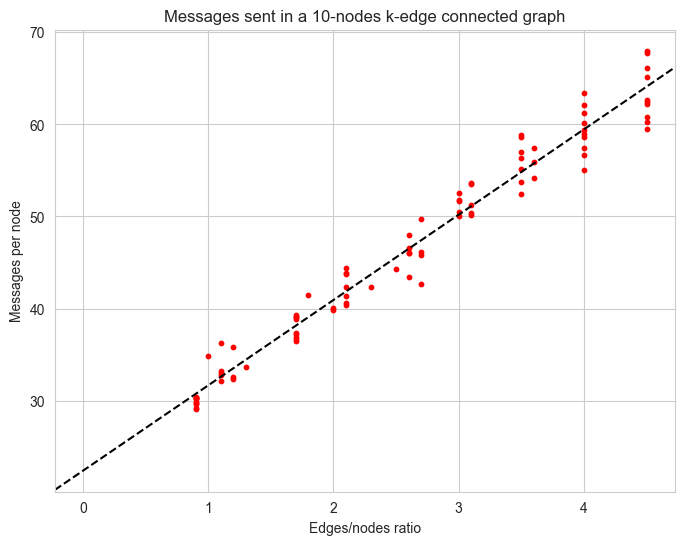

In [7]:
experiments = {
    f"porto_{i}": "red" for i in range(132, 140)
}

experiments["porto_185"] = "red" # 3k


number_of_msg_plot(
    experiments=experiments,
    title="Messages sent in a 10-nodes k-edge connected graph",
    file="plots/messages/by_connectivity_10n.svg",
)

In [28]:
experiments = {
    "porto_140": 6,
    "porto_141": 8,
    "porto_142": 12,
    "porto_143": 14,
    "porto_144": 16,
    "porto_145": 18,
    "porto_146": 20, 
    "porto_147": 22,
}

experiments["porto_185"] = 10

fig, ax = plt.subplots(1, 1, figsize=(8,6))

all_data = []

for exp, num_nodes in experiments.items():
    num_messages = []
    for j in range(NUM_SIMULATIONS):
        folder = Path("experiments") / exp / str(j)
        with (folder / "history.json").open("r") as f:
            history = json.load(f)
        
        num_messages.append(len(history["messages"]) / num_nodes)
        all_data.extend(num_messages)
    
    mean = sum(num_messages) / NUM_SIMULATIONS
    ax.scatter(x=[num_nodes] * NUM_SIMULATIONS, y=num_messages, color="green",  s=30)
    ax.scatter(x=num_nodes, y=mean, color="red", s=30, marker="x")

ax.set_xlabel("Num nodes")
ax.set_ylabel("Messages per node")

plt.savefig("plots/messages/by_n_nodes.svg", dpi=500, format="svg", bbox_inches='tight')

[9.12628535] 23.987058869920332 0.9911975387503767


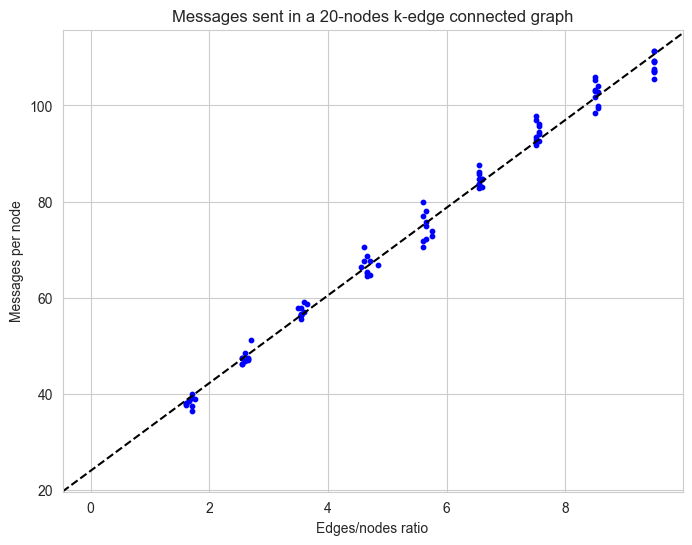

In [20]:
experiments = {
    f"porto_{i}": "blue" for i in range(148, 157)
}

number_of_msg_plot(
    experiments=experiments,
    title="Messages sent in a 20-nodes k-edge connected graph",
    file="plots/messages/by_k_20n.svg",
)

[9.2465793] 22.993793523821292 0.9919013317268626


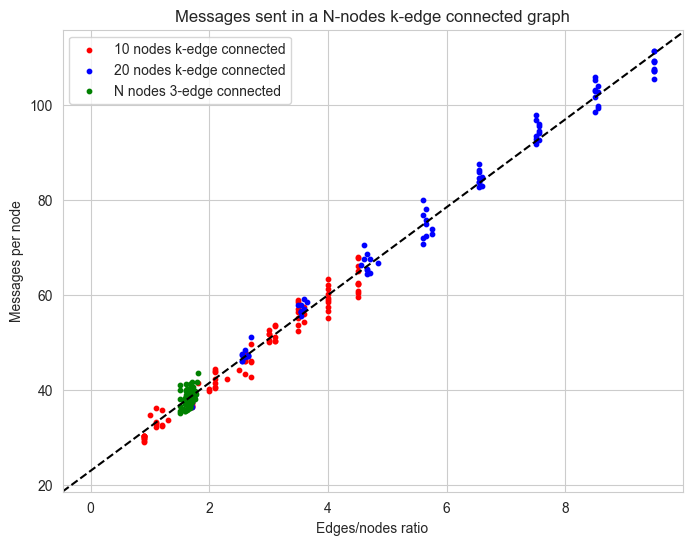

In [9]:
experiments = {
    f"porto_{i}": "red" for i in range(132, 140)
}
experiments.update({
    f"porto_{i}": "blue" for i in range(148, 157)
})
experiments.update({
    f"porto_{i}": "green" for i in range(140, 148)
})

experiments["porto_185"] = "red"


number_of_msg_plot(
    experiments=experiments,
    title="Messages sent in a N-nodes k-edge connected graph",
    file="plots/messages/by_k_10n_20n.svg",
    legend={
        "red": "10 nodes k-edge connected",
        "blue": "20 nodes k-edge connected",
        "green": "N nodes 3-edge connected",
    }
)

[3.25147699] 23.966561244275148 0.9922148154630965
[9.12628535] 23.987058869920332 0.9911975387503767
[2.44398246] 26.235124059451408 0.9893031058105027


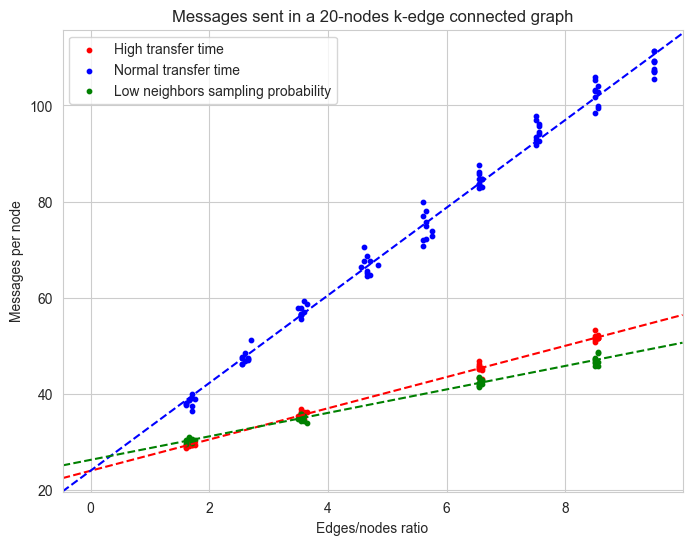

In [4]:
experiments = {
    f"porto_{i}": "red" for i in range(169, 173)
}

experiments.update({
    f"porto_{i}": "blue" for i in range(148, 157)
})

experiments.update({
    f"porto_{i}": "green" for i in range(173, 177)
})


number_of_msg_plot(
    experiments=experiments,
    title="Messages sent in a 20-nodes k-edge connected graph",
    file="plots/messages/high_transfer_time.svg",
    legend={
        "red": "High transfer time",
        "blue": "Normal transfer time",
        "green": "Low neighbors sampling probability",
    },
    fit_by_group=True,
)

In [25]:
experiments = {
    "porto_84": "1",
    "porto_168": "3", 
}

fig, ax = plt.subplots(1, 1, figsize=(8,6))

data = []
for exp, label in experiments.items():
    num_messages = []
    for j in range(NUM_SIMULATIONS):
        folder = Path("experiments") / exp / str(j)
        with (folder / "history.json").open("r") as f:
            history = json.load(f)
        
        num_messages.append(len(history["messages"]) / 10)
    data.append(pd.Series(num_messages, name=label))
    
boxplot(data, file="plots/messages/merged_models.svg", xlabels=[v for v in experiments.values()], x_title="Merged Models", y_title="Sent messages")

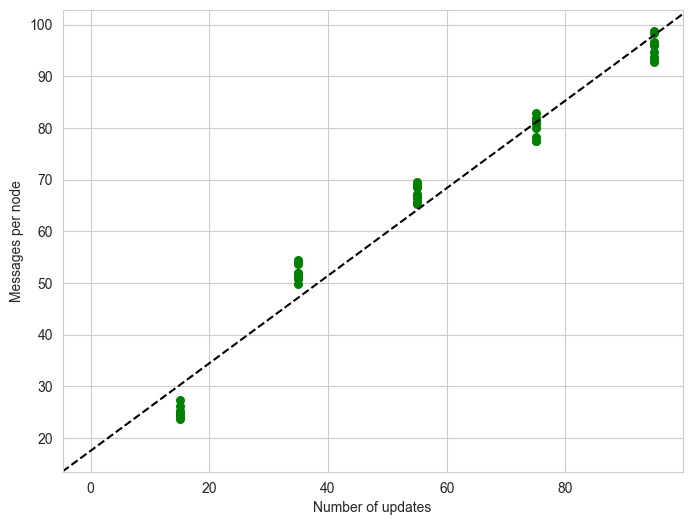

In [7]:
experiments = {
    f"porto_{i}": 15+(i-157)*20 for i in range(157, 162)
}

fig, ax = plt.subplots(1, 1, figsize=(8,6))

all_data = []
updates = []

for exp, num_updates in experiments.items():
    num_messages = []
    for j in range(NUM_SIMULATIONS):
        folder = Path("experiments") / exp / str(j)
        with (folder / "history.json").open("r") as f:
            history = json.load(f)
        
        num_messages.append(len(history["messages"]) / 20)
        
    all_data.extend(num_messages)
    updates.extend([num_updates] * NUM_SIMULATIONS)
        
    ax.scatter(x=[num_updates] * NUM_SIMULATIONS, y=num_messages, color="green",  s=30)
    
model = LinearRegression()
model.fit(np.array(updates).reshape((-1, 1)), np.array(all_data))

ax.axline((0, model.intercept_), slope=model.coef_, color="black", linestyle="dashed")
ax.set_xlabel("Number of updates")
ax.set_ylabel("Messages per node")

plt.savefig("plots/messages/by_updates.svg", dpi=500, format="svg", bbox_inches='tight')

### Time series

In [9]:
import pandas as pd
import numpy as np

series = []

for i in range(10):
    for j in range(10):
        data = pd.read_parquet(f"data/datasets/porto_10n_3k/{i}/node_{j}_notscaled.parquet")
        series.append(data["requests"].to_numpy())
        
all_data = np.concatenate(series)

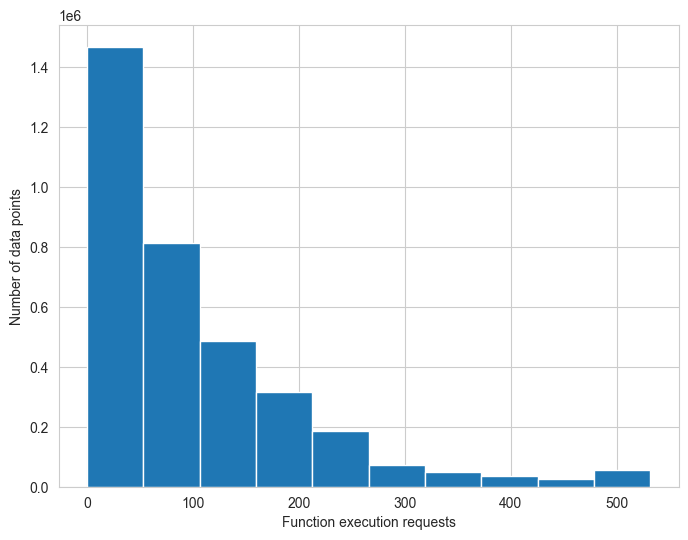

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.hist(
    all_data,
)
ax.set_xlabel("Function execution requests")
ax.set_ylabel("Number of data points")

plt.savefig("plots/time_series/distribution.svg", dpi=500, format="svg", bbox_inches='tight')

### Network load

In [1]:
import pandas as pd
import numpy as np

series = []

data = pd.read_parquet(f"data/datasets/porto_10n_3k/0/node_0_notscaled.parquet")
ts = data["requests"].to_numpy()

dataset_bytes = ts.nbytes

In [2]:
from utils.model_creators import create_LSTM
from gossiplearning.config import Config
import json

with open(f"experiments/porto_80/0/config.json", "r") as f:
    config = json.load(f)

config = Config.model_validate(config)

model = create_LSTM(config)
model.summary()

Metal device set to: Apple M1 Pro


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 9)]            0         
                                                                 
 sequential (Sequential)     (None, 32)                33832     
                                                                 
 fn_0 (Dense)                (None, 1)                 33        
                                                                 
Total params: 33,865
Trainable params: 33,865
Non-trainable params: 0
_________________________________________________________________


In [3]:
model_bytes = 33865 * 4

In [4]:
model_bytes

135460

In [5]:
observed_coeff = 9.2
observed_offset = 22
edge_nodes_ratio = 3
n_nodes = 100

(observed_coeff * edge_nodes_ratio + observed_offset) * model_bytes

6718815.999999999

In [6]:
n_nodes * dataset_bytes

28032000

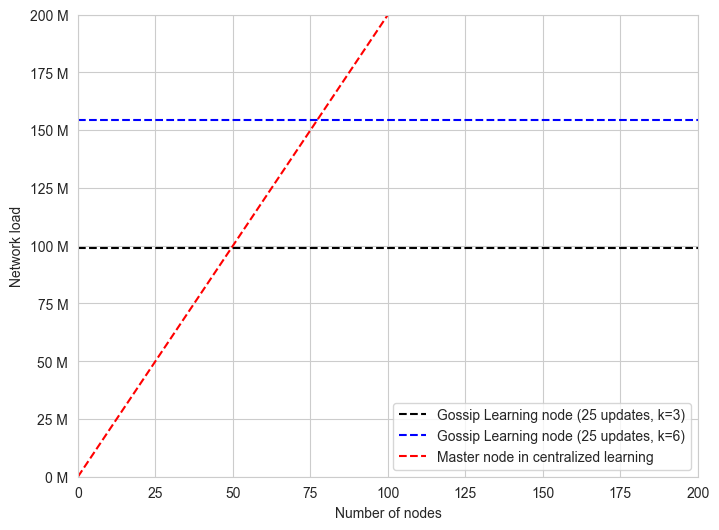

In [16]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.axline((0, 2 * (observed_offset + observed_coeff * 3)), slope=0, color="black", linestyle="dashed", label="Gossip Learning node (25 updates, k=3)")
ax.axline((0, 2 * (observed_offset + observed_coeff * 6)), slope=0, color="blue", linestyle="dashed", label="Gossip Learning node (25 updates, k=6)")
ax.axline((0, 0), slope=2, color="red", linestyle="dashed", label="Master node in centralized learning")

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Network load")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.f M'))
ax.legend(loc="lower right")

plt.savefig("plots/messages/centralized_comparison.svg", dpi=500, format="svg")